<div style="width:80%;height:10px;background:#98C0C5;margin:0 auto;"></div>
<div style="width:90%;height:10px;background:#008190;margin:0 auto;"></div>
<div style="width:100%;height:10px;background:#00B8C6;margin:0 auto;"></div>
<h1 style="text-align:center;margin:5px 0px 5px">Lockheed App Submissions 2020: Summary</h1>
<div style="width:100%;height:5px;background:#00879D;margin:0 auto;"></div>

<div>
    <p style="font-weight: 700">This notebook is a quick exercise to look at my Lockheed Martin applicaiton submission history since the beginning of 2020.  Some notes about the data:
    </p>
    <ul>
        <li>The portion of actually procuring the info from the LMT Careers site isn't executed in this notebook, but some of the processes are noted in the first few cels.</li>
        <li>The full JSON data output is at the bottom of the notebook.</li>
        <li>Some of the job titles and locations names and values are reworked for more of a broader picture.</li>
        <li>Only basic measures are looked at given the sparsity of the data.</li>
    </ul>
</div>


In [2]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import re
import json
import shlex
import base64
import getpass
import zipfile
import requests
import subprocess
import pandas as pd
from datetime import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [3]:
with open(rf"data\lmt-app-data.json") as f:
    data = f.read()

<div style="width:100%;height:20px;background:#800020;"></div>
<h2 style="text-align:center;justify-content: center;">Reformat and Write cUrl Command</h2>

```python
# Get curl data and replace the option "compressed"
# Windows doesn't see to like that.
curl_full = """
curl "https://sjobs.brassring.com/TgNewUI/CandidateZone/Ajax/DashboardData" -H "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:75.0) Gecko/20100101 Firefox/75.0" -H "Accept: */*" -H "Accept-Language: en-US,en;q=0.5" --compressed -H "Content-Type: application/x-www-form-urlencoded; charset=UTF-8" -H "RFT: I0A7nQXubs2m6H7EoSSFUJXTw5dUzJc-hWPmPbccRhGI5WMH2_Y4yS-aw7oqiccE_lMyHMDLKqtHNAr7yg6KQF7RpL1pBTLupLXTk7c0z2Vpr80RAjF3VKwFIl0cyYjzHMxzUQ2" -H "X-Requested-With: XMLHttpRequest" -H "Origin: https://sjobs.brassring.com" -H "Connection: keep-alive" -H "Referer: https://sjobs.brassring.com/TGnewUI/Search/Home/Home?partnerid=25037&siteid=5010&SID="%"5EuzWn76eQnfuKHSk2V9IZpxAVTlsqjKYHA6p"%"2F2gYr"%"2FyLRtRgixz"%"2FL2NpLftZDbFlz" -H "Cookie: tg_session=^X4ZwO2wyayjkEvCTmOKTXUCmccERHZJLPlY3iWSJfPHkjiB/K4lEoVd/g2JddVm0Ckysowqur0CMbfj8hn/O_slp_rhc_6hoW6RLpFP2N6L0q6K4Trs=; tg_session_25037_5010=^X4ZwO2wyayjkEvCTmOKTXUCmccERHZJLPlY3iWSJfPHkjiB/K4lEoVd/g2JddVm0Ckysowqur0CMbfj8hn/O_slp_rhc_6hoW6RLpFP2N6L0q6K4Trs=; tg_rft=^LQ2UYNmOjeBS6hc/OXFk464HSfCdmdpPZrWEDCe3avWrmjISZVl7A+BnX7vwaCkZYWCEeBguXnIJcmiOPaQFzv60Jfq8b6rdacaAzMsPXTQ=; _ga=GA1.2.1079982286.1588888529; _gid=GA1.2.435012303.1588888529; __utma=49580644.1079982286.1588888529.1588888529.1588888529.1; __utmc=49580644; __utmz=49580644.1588888529.1.1.utmcsr=duckduckgo.com|utmccn=(referral)|utmcmd=referral|utmcct=/; __utma=49580644.1079982286.1588888529.1588888529.1588888529.1; __utmc=49580644; __utmz=49580644.1588888529.1.1.utmcsr=duckduckgo.com|utmccn=(referral)|utmcmd=referral|utmcct=/; tg_rft_mvc=FQ9dji-Qw-zNbTFsPzHh_iOSGAi16Rb9tec_66JIRiatAk4TZUsFKelxFLIVm6YH1L9ztSezVJkWHOuYkDWNHD4cuGaAanb1bytW0lXgIhb9cho5WRyAQf0rlrOLboBxOGCGFg2; G_ENABLED_IDPS=google" --data "ClientId=25037&SiteId=5010&SessionID="%"5EX4ZwO2wyayjkEvCTmOKTXUCmccERHZJLPlY3iWSJfPHkjiB"%"2FK4lEoVd"%"2Fg2JddVm0Ckysowqur0CMbfj8hn"%"2FO_slp_rhc_6hoW6RLpFP2N6L0q6K4Trs"%"3D&ConfiguredJobTitle=jobtitle&Tab=2"
""".strip()

curl_full = curl_full.replace(" --compressed","")

# Write to local drive
with open(rf"{PROJECT_DIR}\data\lmt-curl-cmd.txt", mode='w',) as f:
    f.write(curl_full)
    
print("\n-H".join(re.split(r"\s+-H", curl_full)))
```

<div style="width:100%;height:10px;background:#004D71;margin-bottom:5px"></div>

<div style="width:100%;height:20px;background:#800020;"></div>
<h2 style="text-align:center;justify-content: center;">Run Process to Gather Data</h2>

```python
# Run try/except to gather and process application data.
try:
    
    # Tokenize curl command in POSIX format to excuse any percent signs as wildcards.
    tokens = shlex.split(curl_full, posix=True)

    p = subprocess.Popen(tokens, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    
    stdout, stderr = p.communicate()
    
except subprocess.CalledProcessError:
    stdout, stderr = p.communicate()
    print(stdout, stderr)
```

<div style="width:100%;height:10px;background:#004D71;margin-bottom:5px"></div>

<div style="width:100%;height:20px;background:#800020;"></div>
<h2 style="text-align:center;justify-content: center;">Function: Navigate Dictionary</h2>

```python
def unravel_questions(iterable, **kwargs):
    """
    Function to get certain keywords from subquestions and reuturn
    a key-value collection.
    """
    ddict = dict()
    for i in range(len(iterable)):
        for k, v in iterable[i].items():
            if v in kwargs.keys():
                term = kwargs[v]
                val = iterable[i].get("Value")
                ddict[term] = val
    return ddict
```

<div style="width:100%;height:10px;background:#004D71;margin-bottom:5px"></div>

<div style="width:100%;height:20px;background:#800020;"></div>
<h2 style="text-align:center;justify-content: center;">Process JSON Response Data into Pandas DataFrame</h2>
<br>

```python
# Convert stdout to unicode and restructure as json.
data_dict = json.loads(data)


# Application data from user data json result
app_data = data_dict.get("DashboardData").get("Applications")


# Get number of current applicaitons that have been submitted.
app_cnt = app_data.get("AppliedCount")


apps = app_data.get("AppliedJobs")

# Keywords from each application data set that we want to keep
v_kwrds = (
        "JobTitle",
        "ReqId",
        "Status",
        )

# Date keys to reformat before adding to results collection.
dt_kwrds = (
        "LastUpdated",
        "JobSubmissionDate",
        "ReqStatusDate",
        )

# Keywords and 'normal' names for questions that we want to keep
# The keys in this collection are used to match values and return
# values from the 'Value' key in the question collection.
q_kwargs = {
        "formtext13": "Unit",
        "formtext27": "Location",
        "autoreq": "AutoReq",
        }


ddict = dict()
for ix, app in enumerate(apps):

    ddict[ix] = dict()


    for k, v in app.items():
        if k in dt_kwrds:
            ddict[ix][k] = dt.strptime(v, "%d-%b-%Y").strftime("%Y-%m-%d")
        elif k in v_kwrds:
            ddict[ix][k] = v



    # Get Quesions and create key-value collection of focus items
    qs = app.get("Questions")
    for k, v in unravel_questions(qs, **q_kwargs).items():
        ddict[ix][k] = v
        
        
    # Write json
    with open(rf"{PROJECT_DIR}\lmt-app-data.json", mode='w',) as f:
        f.write(json.dumps(ddict, sort_keys=True, indent = 4))        
```

<div style="width:100%;height:10px;background:#004D71;margin-bottom:5px"></div>

<div style="width:100%;height:10px;background:##60750A;margin-bottom:5px"></div>
<h2 style="text-align:center;padding:0;margin:0">Create DataFrame From JSON</h2>

In [4]:
# Load preprocessed data
ddict = json.loads(data)

# Date fields
dt_cols = [
    "LastUpdated",
    "JobSubmissionDate",
    "ReqStatusDate",
    ]

# Restructuring data as Pandas DataFrame
df = pd.DataFrame([v for v in ddict.values()], index=[i for i in ddict.keys()])

new_order = ['ReqId',
             'AutoReq',
             'JobTitle',
             'Unit',
             'Location',
             'LastUpdated',
             'JobSubmissionDate',
             'Status',
             'ReqStatusDate',
            ]

df = df.loc[:, new_order]

# Replace Locations that have multiple values with 'Multiple'
df_loc_cnt = df.loc[:, "Location"].str.split(",", expand=True).count(axis=1)
df.loc[df_loc_cnt>1, "Location"] = "Multiple"
df.loc[:, "Location"] = df.loc[:, "Location"].str.strip()

# Reformat datetime fields to appropriate type
df.loc[:, dt_cols] = df.loc[:, dt_cols].apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))


df.sort_values(by=["ReqId","AutoReq"], inplace=True, ignore_index=True)

<div style="width:100%;height:10px;background:##60750A;margin-bottom:5px"></div>
<h2 style="padding:5px 0px 5px 0px;text-align:center;;padding:0;margin:0">DataFrame info</h2>

In [7]:
app_count = df.shape[0]
print(f"In total, there are {app_count} application submissions in this dataset.\nBelow is a bit more information about the attributes and overall size of the data.\n\n")
print(df.info())

In total, there are 31 application submissions in this dataset.
Below is a bit more information about the attributes and overall size of the data.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ReqId              31 non-null     int64         
 1   AutoReq            31 non-null     object        
 2   JobTitle           31 non-null     object        
 3   Unit               31 non-null     object        
 4   Location           31 non-null     object        
 5   LastUpdated        31 non-null     datetime64[ns]
 6   JobSubmissionDate  31 non-null     datetime64[ns]
 7   Status             31 non-null     object        
 8   ReqStatusDate      31 non-null     datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(5)
memory usage: 2.3+ KB
None


In [8]:
# Clean up job titles

titlelist = list(df.loc[:, "JobTitle"].unique())

jtdf = df.loc[:, "JobTitle"].to_frame()
jtdf["JobTitleBasic"] = None

def update_title(kwrd, repl=None):
    if not repl is None:
        jtdf.loc[((jtdf["JobTitle"].str.contains(kwrd))&(jtdf["JobTitleBasic"].isna())),"JobTitleBasic"] = repl
    else:
        jtdf.loc[((jtdf["JobTitle"].str.contains(kwrd))&(jtdf["JobTitleBasic"].isna())),"JobTitleBasic"] = kwrd


update_title("Data Science Analyst")
update_title("Senior Data Analyst")
update_title("Data Engineer")
update_title("AI Engineer", "Data Scientist / AI Engineer ")
update_title("Data Scientist")
update_title("Machine Learning")
update_title("Software Engineer")
update_title("Developer", "Software Developer")

# Merge column into new dataframe
df2 = df.merge(jtdf.loc[:, "JobTitleBasic"], 'inner', left_index=True, right_index=True)
df2["yearmonth"] = df2["JobSubmissionDate"].dt.strftime("%Y-%b")
df2["line"] = 1

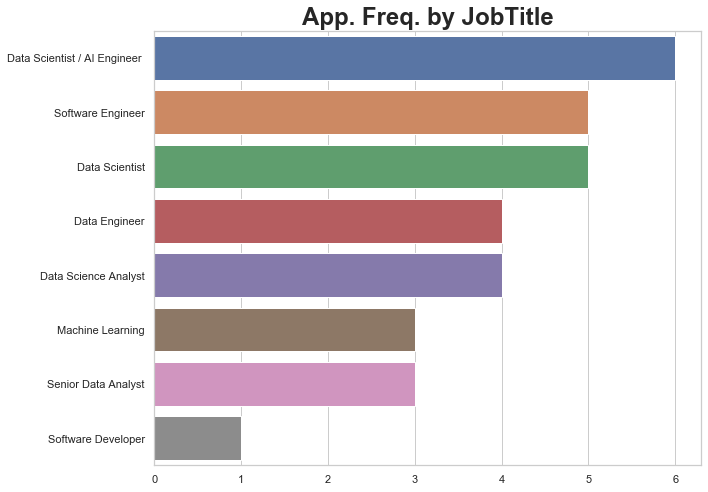

In [9]:
plt.rcParams["figure.figsize"] = 9,7

jt_ct = jtdf.loc[:, "JobTitleBasic"].value_counts()

f, ax = plt.subplots(figsize=(10, 7))
g = sns.barplot(jt_ct.values, jt_ct.index, orient="h", ax=ax)
g.set_title("App. Freq. by JobTitle", fontdict={'fontsize': 24,'fontweight' : "bold",})
plt.tight_layout()
plt.show()

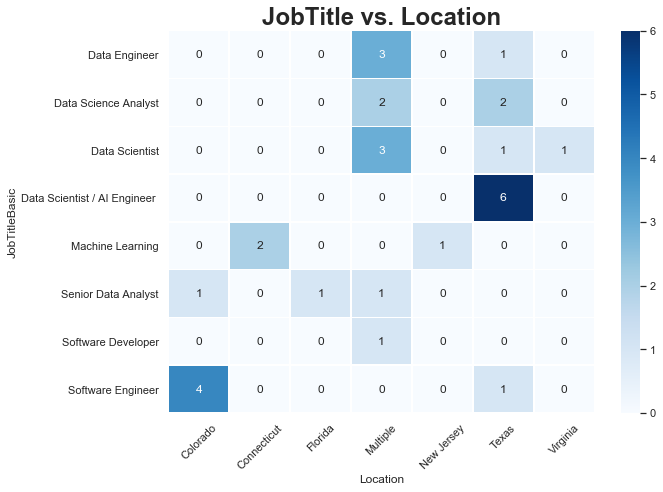

In [10]:
# Crosstab of Location and JobTitle
ct = pd.crosstab(df2["JobTitleBasic"], df2["Location"], margins=False)


# Plot heatmap
f, ax = plt.subplots(figsize=(10, 7))
g = sns.heatmap(ct, cmap=plt.cm.Blues, annot=True, fmt="d", linewidths=.5, ax=ax)
bottom, top = ax.get_ylim()
g.set_title("JobTitle vs. Location", fontdict={'fontsize': 24,'fontweight' : "bold",})
g.set_ylim(bottom + 0.5, top - 0.5)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

<h3>In the above plot, please note that the Multiple category reduces granularity.  The Data Engineer role, for instance, is located in Colorado, Connecticut, and New York.</h3>

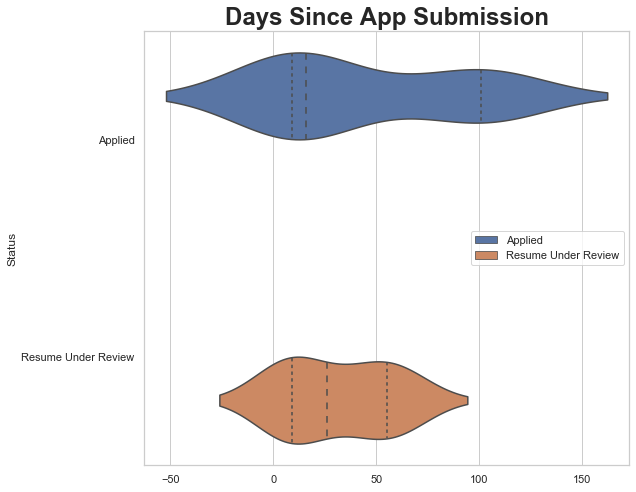

In [11]:
# Plot 3: Days Since Submission distribution
today = dt.today()

# Job submissions still in the running
df_alive = df2.loc[~df2["Status"].str.startswith("No longer"), ["ReqId","JobSubmissionDate", "LastUpdated", "Status"]]

# Also tried for a "days since update" attribute, but the data wasn't that much different
df_alive["DaysSinceSubmission"] = (dt.today() - df2["JobSubmissionDate"]).dt.days


fig, ax = plt.subplots(figsize=(9, 7))
g = sns.violinplot(y="Status", x="DaysSinceSubmission", inner="quartile", data=df_alive, orient="h", hue="Status", legend=None)
g.set_title("Days Since App Submission", fontdict={'fontsize': 24,'fontweight' : "bold",})
ax.legend(loc=7)
ax.set_xlabel('')
plt.tight_layout()
plt.show()


<div style="width:100%;height:10px;background:##60750A;margin-bottom:5px"></div>
<h2 style="padding:5px 0px 5px 0px;text-align:center;;padding:0;margin:0">Summary</h2>

In [25]:
df_rejections = df2.loc[df2["Status"].str.startswith("No longer"),:]
rej_ct = df_rejections.shape[0]

earliest_rem_app_sub_dt = df_alive["JobSubmissionDate"].min()
earliest_rem_app_sub_dt = earliest_rem_app_sub_dt.strftime("%Y-%m-%d") # YYYY-MM-DD

highest_app_count = jt_ct.nlargest(1).index[0]

print(f"App count: {app_count}\nRejections: {rej_ct}\nRemaining: {app_count - rej_ct}")
print(f"Earliest Submission Date (remaining apps): {earliest_rem_app_sub_dt}")
print(f"JobTitle highest app submission count: '{highest_app_count.strip()}'")

App count: 31
Rejections: 17
Remaining: 14
Earliest Submission Date (remaining apps): 2020-01-28
JobTitle highest app submission count: 'Data Scientist / AI Engineer'


#### We can see from the basic metric above there there were 31 total submissions and 14 apps are still active.  However, with the earliest app having been submitted in January and three within that time frame, it doesn't seem likely that those will be moving forward.

#### Notably, the job title with the highest application submission count is 'Data Scientist / AI Engineer.'  However, given that many of the job titles didn't fit a particualr format, that number could change with a little bit more analysis.  Some job titles were very similar, so going the other direction in terms of naming convetion would produce slightly different results, as an example.

<div style="margin-top:25px">
    <div style="width:80%;height:10px;background:#6580CD;margin:0 auto;"></div>
    <div style="width:90%;height:10px;background:#2CA6E2;margin:0 auto;"></div>
    <div style="width:100%;height:10px;background:#2BC7E2;margin:0 auto;"></div>
    <h2 style="padding:5px 0px 5px 0px;text-align:center;;padding:0;margin:0">Raw JSON Data</h2>
    <div style="width:100%;height:10px;background:#2BC7E2;margin:0 auto;"></div>
    <div style="width:90%;height:10px;background:#2CA6E2;margin:0 auto;"></div>
    <div style="width:80%;height:10px;background:#6580CD;margin:0 auto;"></div>
</div>

In [33]:
print(json.dumps(ddict, indent=4, sort_keys=True))

{
    "0": {
        "AutoReq": "521509BR",
        "JobSubmissionDate": "2020-03-10",
        "JobTitle": "Flight Software Engineer",
        "LastUpdated": "2020-05-05",
        "Location": "Colorado",
        "ReqId": 605008,
        "ReqStatusDate": "2020-05-05",
        "Status": "No longer under consideration for position",
        "Unit": "Space"
    },
    "1": {
        "AutoReq": "515929BR",
        "JobSubmissionDate": "2020-04-29",
        "JobTitle": "Data Scientist / AI Engineer",
        "LastUpdated": "2020-05-05",
        "Location": "Texas ",
        "ReqId": 542034,
        "ReqStatusDate": "2020-04-28",
        "Status": "Resume Under Review",
        "Unit": "Enterprise Operations "
    },
    "10": {
        "AutoReq": "525660BR",
        "JobSubmissionDate": "2020-04-29",
        "JobTitle": "Data Science Analyst / Python / analystics / Production Manufacturing",
        "LastUpdated": "2020-04-29",
        "Location": "Alabama, Arkansas, California, Florida, Mas